In [22]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read
from scipy.signal import find_peaks

In [51]:
trigger_file = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm'
trig = wfm2read(trigger_file)
trig_x, trig_y = trig[1], trig[0]
trig_y = trig_y / (2* np.max(trig_y))

path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/*.wfm'
files = glob(path)

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/sca_waveform.wfm starting at index 0 with step 1


# Smooth files and calculate drift time and trigger delay

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_1Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_11Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_13Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_3Wfm.wfm starting at index 0 with step 1
Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/w

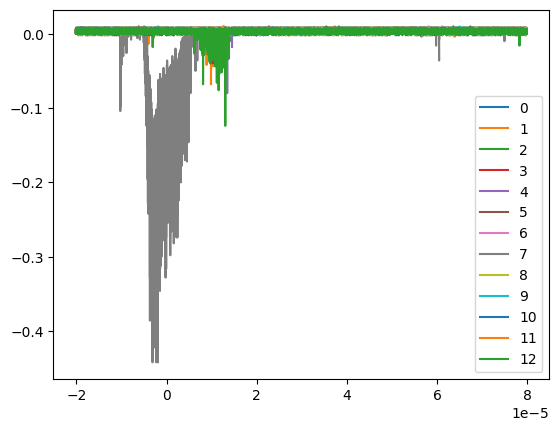

In [18]:
for i,f in enumerate(files):
    wf = wfm2read(f)
    x, y = wf[1], wf[0]
    plt.plot(x, y, label=i)
plt.legend()
# plt.gca().set(xlim=(0.75e-5, 2e-5))

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_10Wfm.wfm starting at index 0 with step 1


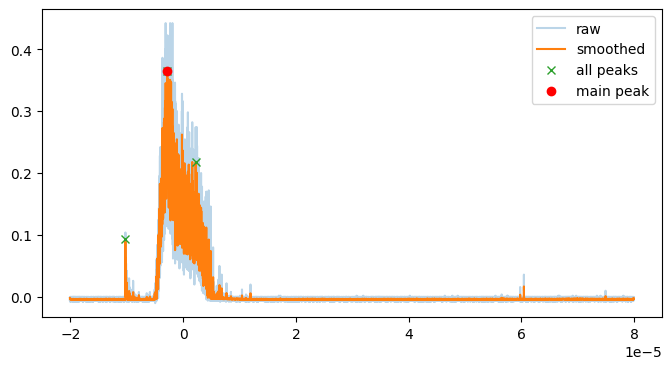

In [85]:
# …existing code…
file7 = files[7]
wf     = wfm2read(file7)
x, y   = wf[1], -wf[0]

# 1) smooth with a simple moving average
window   = 50
kernel   = np.ones(window) / window
y_smooth = np.convolve(y, kernel, mode='same')

# 2) find all peaks in the smoothed trace
peaks, props = find_peaks(
    y_smooth,
    height=np.max(y_smooth)*0.2,
    distance= len(x) / 20,
)

# 3) select the main (highest) peak
main_peak = peaks[np.argmax(props['peak_heights'])]

# 4) plot raw, smoothed, all peaks and main peak
plt.figure(figsize=(8,4))
plt.plot(x, y,        alpha=0.3, label='raw')
plt.plot(x, y_smooth,           label='smoothed')
plt.plot(x[peaks],   y_smooth[peaks], 'x', label='all peaks')
plt.plot(x[main_peak], y_smooth[main_peak], 'ro', label='main peak')
plt.legend()
# …existing code…

Rise time (10→90%): 7142.06 ns


Text(-3.118569696969698e-06, 0.3276400105446577, '90%')

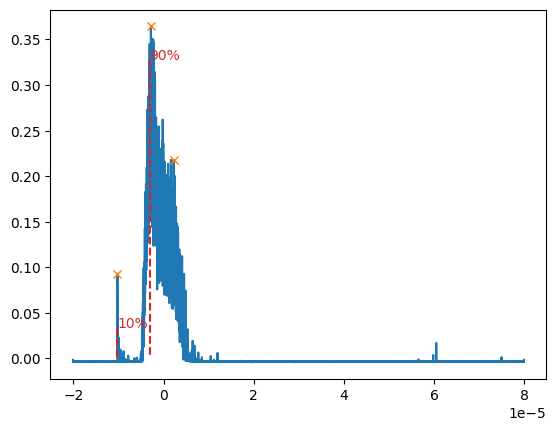

In [64]:
# calculate 10–90% rise time
baseline   = np.median(y_smooth[:main_peak])       # or np.min if you prefer
peak_value = y_smooth[main_peak]

thr10 = baseline + 0.1*(peak_value - baseline)
thr90 = baseline + 0.9*(peak_value - baseline)

# take only the rising segment up to the peak
rseg = y_smooth[:main_peak+1]
xseg = x[:main_peak+1]

# find first indices above each threshold
i10 = np.where(rseg >= thr10)[0][0]
i90 = np.where(rseg >= thr90)[0][0]

# linear interp for more accurate crossing time
t10 = np.interp(thr10, [rseg[i10-1], rseg[i10]], [xseg[i10-1], xseg[i10]])
t90 = np.interp(thr90, [rseg[i90-1], rseg[i90]], [xseg[i90-1], xseg[i90]])

rise_time = t90 - t10
print(f"Rise time (10→90%): {rise_time*1e9:.2f} ns")

plt.plot(x, y_smooth,           label='smoothed')
plt.plot(x[peaks],   y_smooth[peaks], 'x', label='all peaks')

# optional: annotate on your plot
plt.vlines([t10, t90], [thr10, thr90], [0.0, 0.0], linestyles='--', colors='C3')
plt.text(t10, thr10,  '10%', color='C3')
plt.text(t90, thr90,  '90%', color='C3')

In [82]:
cond1 = peaks[0] < main_peak
x_s1 = x[peaks[0]] if cond1 else None
x_s2 = x[main_peak] if cond1 else None
drift_time = x[main_peak] - x[peaks[0]] if cond1 else None
print(f"Drift time: {drift_time*1e9:.2f} ns")

Drift time: 7430.20 ns


Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_10Wfm.wfm starting at index 0 with step 1


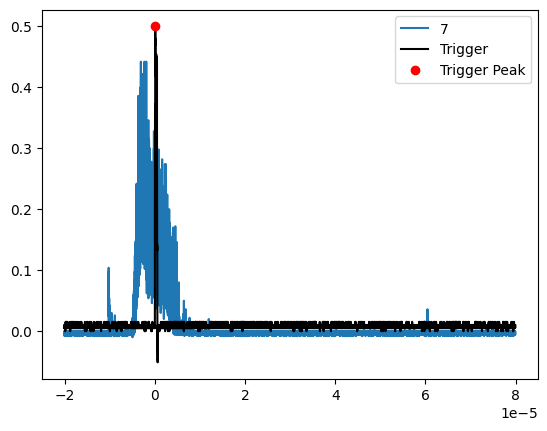

In [75]:
file7 = files[7]
wf = wfm2read(file7)
x, y = wf[1], -wf[0]
plt.plot(x, y, label=7)
plt.plot(trig_x, trig_y, label='Trigger', color='black')
peak_trig = np.argmax(trig_y)
plt.plot(trig_x[peak_trig], trig_y[peak_trig], 'ro', label='Trigger Peak')

plt.legend()

In [83]:
cond2 = peaks[0] < peak_trig
trigger_delay = trig_x[peak_trig] - x_s1 if cond2 else None
s2_amp = y[main_peak] if cond1 and cond2 else None
s1_amp = y[peaks[0]] if cond1 and cond2 else None
print(f"Trigger delay: {trigger_delay*1e9:.2f} ns")

Trigger delay: 10332.80 ns


# Calculate area S2

[(-5e-06, 1.02e-05)]

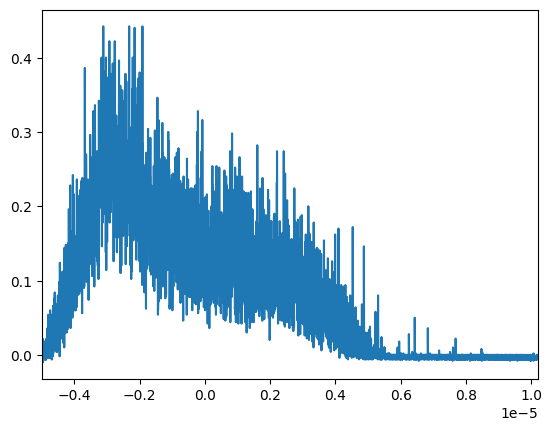

In [100]:
plt.plot(x, y, label='Waveform')
plt.gca().set(xlim=(-0.50e-5, 1.02e-5))

Reading 500000 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/gas_circulation/GasCirculation_5GSsec_TriggerSCA/RUN1_16082025_Gate_Anode2100_2bar_297K_P22_10Wfm.wfm starting at index 0 with step 1
S1 rise time: 7.8 ns, S2 rise time: 7142.0 ns
S2 area: 1.197 uV·s


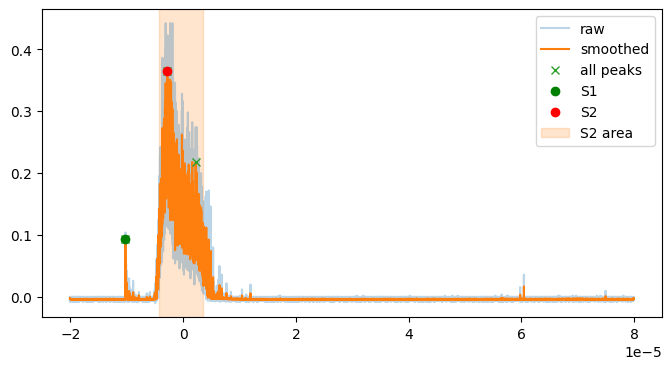

In [108]:
# …existing code above…

file7    = files[7]
wf       = wfm2read(file7)
t, V     = wf[1], -wf[0]

# 1) smooth
window   = 50
V_s      = np.convolve(V, np.ones(window)/window, mode='same')

# 2) find candidate peaks
peaks, props = find_peaks(
    V_s,
    height=np.max(V_s)*0.2,
    distance=len(t)/20
)

# 3) compute 10–90% rise time for each peak
rise_times = []
for pi in peaks:
    seg   = V_s[:pi+1]
    tseg  = t[:pi+1]
    base  = np.median(seg[:window])
    amp   = seg[pi] - base

    thr10 = base + 0.1*amp
    thr90 = base + 0.9*amp

    i10 = np.where(seg >= thr10)[0][0]
    i90 = np.where(seg >= thr90)[0][0]

    t10 = np.interp(thr10, seg[[i10-1, i10]], tseg[[i10-1, i10]])
    t90 = np.interp(thr90, seg[[i90-1, i90]], tseg[[i90-1, i90]])
    rise_times.append(t90 - t10)

rise_times = np.array(rise_times)

# 4) classify S1/S2 by rise time
i_s1    = peaks[np.argmin(rise_times)]
i_s2    = peaks[np.argmax(rise_times)]
s1_t    = t[i_s1];   s1_amp = V_s[i_s1]
s2_t    = t[i_s2];   s2_amp = V_s[i_s2]

# 5) integrate under S2 (between the two 10% crossings)
base_s2   = np.median(V_s[:i_s2])
thr10_s2  = base_s2 + 0.1*(s2_amp - base_s2)

# left edge: last sample before S2 crossing up
left_idx  = np.where(V_s[:i_s2] < thr10_s2)[0][-1]
# right edge: first sample after S2 crossing back down
down_rel  = np.where(V_s[i_s2:] < thr10_s2)[0]
right_idx = i_s2 + (down_rel[0] if down_rel.size else len(V_s)-1)

area_s2 = np.trapz(V[left_idx:right_idx], t[left_idx:right_idx])
area_s2 *= 1e6  # convert to uV·s

print(f"S1 rise time: {rise_times.min()*1e9:.1f} ns, "
      f"S2 rise time: {rise_times.max()*1e9:.1f} ns")
print(f"S2 area: {area_s2:.3f} uV·s")

# 6) re-plot
plt.figure(figsize=(8,4))
plt.plot(t, V,       alpha=0.3, label='raw')
plt.plot(t, V_s,               label='smoothed')
plt.plot(t[peaks], V_s[peaks], 'x', label='all peaks')
plt.plot(s1_t,     s1_amp,     'go', label='S1')
plt.plot(s2_t,     s2_amp,     'ro', label='S2')
plt.axvspan(t[left_idx], t[right_idx],
            color='C1', alpha=0.2, label='S2 area')
plt.legend()

In [110]:
rise_times

array([7.77571770e-09, 7.14203112e-06, 6.50651759e-06])